# Training Pipeline

### Imports

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.optim import Adam
from torchvision.transforms import  Compose, ToTensor, Resize, RandomHorizontalFlip, RandomRotation, ColorJitter, RandomResizedCrop, Lambda
from PIL import Image
import matplotlib.pyplot as plt
from torchsummary import summary
import torchmetrics

In [20]:
num_workers = 0

device = torch.device("cpu")


### MacOS

Set start method to fork and device to metal

In [2]:
import torch.multiprocessing as mp
mp.set_start_method("fork", force=True)  # Ensure fork is used on macOS

device = torch.device("cpu")

if torch.mps.is_available():
    #torch.mps.set_buffer_capacity(1)
    #torch.mps.set_reuse_buffers(True)
    #torch.mps.initialize()
    device = torch.device("mps")
    num_workers = 11

ValueError: cannot find context for 'fork'

### Linux

In [3]:
print("CUDA verfügbar:", torch.cuda.is_available())
print("CUDA-Version:", torch.version.cuda)
print("GPU-Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Keine GPU gefunden")

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_workers = 19


CUDA verfügbar: False
CUDA-Version: None
GPU-Name: Keine GPU gefunden


# Load Datasets

In [3]:
# Dataset Path
DATASET_PATHS = ["../Dataset/MIT-Dataset"]
DATASET_PATHS_TEST = ["../Dataset/test"]
DATASET_PATHS_VALID = [] # Not used yet
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 32
SEED = 42

Set seed 

In [4]:
from lightning.pytorch import seed_everything

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
seed_everything(SEED)

ModuleNotFoundError: No module named 'lightning'

In [5]:
# Custom Dataset
def load_image_label(file_name, dataset_path):
    """Helper function to load image and label from a given file."""
    # Load Image
    image_path = os.path.join(dataset_path, file_name)
    image = Image.open(image_path).resize(IMAGE_SIZE)
    image = np.array(image, dtype=np.float32) / 255.0  # Normalize
    # Load Label
    txt_file = file_name.replace(".jpg", ".txt")
    txt_path = os.path.join(dataset_path, txt_file)
    label = None
    if os.path.exists(txt_path):
        with open(txt_path, "r") as f:
            lines = f.readlines()
            if len(lines) >= 2:
                try:
                    label = float(lines[1].split()[-1])
                except ValueError:
                    print(f"Fehler beim Lesen des Preises in Datei: {txt_path}")
    if label is None:
        raise ValueError(f"Label konnte nicht geladen werden: {txt_file}")
    return image, label

## Custom augmentation

In [6]:
import random
from PIL import Image, ImageEnhance

def custom_augmentation(image):
    
    
    noise_factor = random.uniform(0.01, 0.1)
    image = add_random_noise(image, noise_factor)
    
    return image

def add_random_noise(image, noise_factor=0.1):
    """
    Fügt zufälliges Rauschen zu einem Bild hinzu.
    """
    np_image = np.array(image)  # Konvertiere das Bild zu einem numpy-Array
    noise = np.random.randn(*np_image.shape) * noise_factor  # Erzeuge Rauschen
    noisy_image = np_image + noise * 255  # Skaliere das Rauschen zu den Bildwerten
    noisy_image = np.clip(noisy_image, 0, 255)  # Begrenze den Wertebereich
    return Image.fromarray(np.uint8(noisy_image))  # Konvertiere zurück zu einem PIL-Image


In [13]:

class ImagePriceDataset(Dataset):
    def __init__(self, dataset_paths, transform=None):
        self.files = []
        for dataset_path in dataset_paths:
            if not os.path.exists(dataset_path):
                raise ValueError(f"Path {dataset_path} doesn't exist.")
            for f in os.listdir(dataset_path):
                if f.endswith(".jpg"):
                    self.files.append((f, dataset_path))
        
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_name, dataset_path = self.files[idx]
        image, label = load_image_label(file_name, dataset_path)

        # Wenn das Bild im float32 Format vorliegt, skaliere es und wandle es in uint8 um
        if image.dtype == np.float32:
            image = (image * 255).astype(np.uint8)  # Skalieren auf [0, 255] und in uint8 umwandeln

        # Konvertiere das numpy-Array in ein PIL-Image
        image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)
    
# Transforms
transform = Compose([
    #Resize(IMAGE_SIZE),               # Skaliere die Bilder auf die gewünschte Größe
    #Lambda(lambda x: custom_augmentation(x)),
    RandomHorizontalFlip(p=0.5),       # Zufälliges horizontales Spiegeln mit 50% Wahrscheinlichkeit
    RandomRotation(degrees=180),        # Zufällige Rotation um bis zu ±15 Grad
    RandomResizedCrop(IMAGE_SIZE, scale=(0.9, 1.0)),
    ColorJitter(brightness=0.03,        # Zufällige Anpassung der Helligkeit
                contrast=0.1,          # Kontrast
                saturation=0.1,        # Sättigung
                hue=0.03),              # Farbton
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

transform_test = Compose([
    ToTensor()                         # Konvertiere das Bild zu einem Tensor
])

# Dataset
train_dataset = ImagePriceDataset(DATASET_PATHS, transform=transform)
test_dataset = ImagePriceDataset(DATASET_PATHS_TEST, transform_test)
# Train-Valid Split
if len(DATASET_PATHS_VALID) > 0:
    val_dataset = ImagePriceDataset(DATASET_PATHS_VALID, transform=transform)
else:    
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)


## Test Augmentation

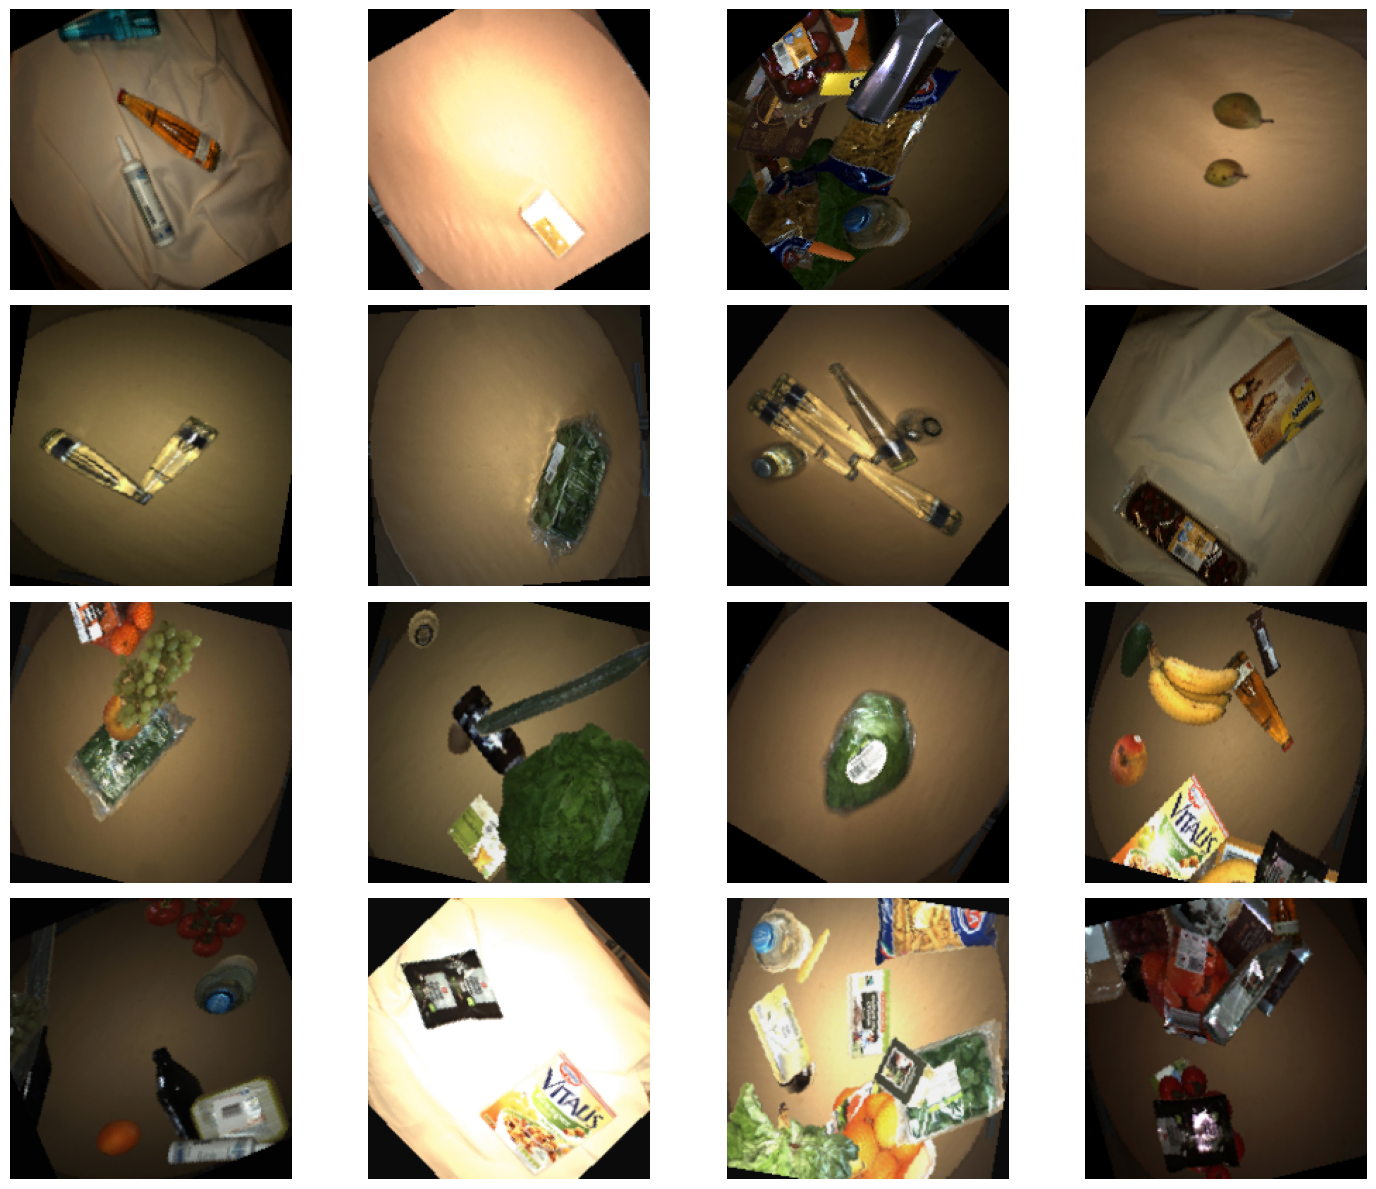

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Funktion zum Anzeigen von Bildern
def imshow(image, ax=None):
    # Wenn kein Ax angegeben wird, erstelle eine neue Achse
    if ax is None:
        fig, ax = plt.subplots()
        
    # Wandle den Tensor in ein NumPy-Array um und skaliere die Werte zurück auf [0, 1]
    image = image.permute(1, 2, 0).numpy()  # Von (C, H, W) nach (H, W, C)
    image = np.clip(image, 0, 1)  # Begrenze den Wertebereich auf [0, 1]
    
    ax.imshow(image)
    ax.axis('off')

# Hole ein Batch von Bildern aus dem DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Zeige die ersten 5 Bilder im Batch
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4 Zeilen, 5 Spalten
axes = axes.flatten()  # Flatten der 2D Achsenmatrix, um sie einfach zu durchlaufen

# Zeige die Bilder
for i in range(16):
    imshow(images[i], axes[i])  # Stelle jedes Bild in der jeweiligen Achse dar

# Zeige die Bilder
plt.tight_layout()  # Optimiert das Layout für bessere Übersicht
plt.show()


## Weights & Biases

## Build Model

In [15]:
# Lightning Module
class RegressionModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, 128),  # Anpassung je nach Bildgröße
            nn.ReLU(),
            nn.Linear(128, 1)  # Regression Output
        )
        self.criterion = nn.MSELoss()
        self.mae = torchmetrics.MeanAbsoluteError()
        self.mse = torchmetrics.MeanSquaredError()
        self.learning_rate = learning_rate
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Progress-Bar und Training
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_mae", mae, prog_bar=True, on_epoch=True)
        self.log("train_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)  # Entferne die überflüssige Dimension
        loss = self.criterion(y_pred, y)

        # Berechne zusätzliche Metriken
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        # Logs für Validation
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_mae", mae, prog_bar=True, on_epoch=True)
        self.log("val_mse", mse, prog_bar=True, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze(-1)
        loss = self.criterion(y_pred, y)
        mae = self.mae(y_pred, y)
        mse = self.mse(y_pred, y)

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mae", mae, prog_bar=True)
        self.log("test_mse", mse, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        
        # Erstelle einen Scheduler
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.95)
        # Alternativ: andere Scheduler wie CosineAnnealingLR, ReduceLROnPlateau, etc.
        
        return [optimizer], [scheduler]
    
    #def train_dataloader(self):

        #return super().train_dataloader()
    
    #def val_dataloader(self):


## Training

### Callbacks:

In [16]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',   # Track validation loss
    dirpath='checkpoints/',  # Directory to save checkpoints
    filename='best-checkpoint',  # Checkpoint file name
    save_top_k=1,  # Save only the best model (lowest val_loss)
    mode='min',  # We are minimizing validation loss
)

In [21]:

from lightning.pytorch.loggers import WandbLogger
import wandb
from datetime import datetime
# WANDB stuff

# Sort the dataset names alphabetically
dataset_names = "-".join(sorted([os.path.basename(path) for path in DATASET_PATHS]))

group = "Regression-"+dataset_names
name = dataset_names+"_"+datetime.now().strftime("%d%b-%H:%M:%S")

wandb_logger = WandbLogger(project="TinyML-CartDetection", group=group, name=name)

model = RegressionModel()

# Log additional hyperparameters
wandb_logger.experiment.config.update({"batch_size": BATCH_SIZE, "image_size": IMAGE_SIZE, "seed": SEED})

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=30, logger=wandb_logger, callbacks=[checkpoint_callback], fast_dev_run=False, accelerator=str(device), devices=1)

# Model Training
trainer.fit(model, train_loader, test_loader)

# Load the best checkpoint (lowest validation loss)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Load the best model for testing
model = RegressionModel.load_from_checkpoint(best_model_path)

# Model Testing
trainer.test(model, test_loader)

# Metrics and predictions
metrics = trainer.callback_metrics

def show_predictions(model, test_dataset, num_samples=20):
    model.eval()  # Setze das Modell in den Evaluierungsmodus
    samples = random.sample(range(len(test_dataset)), num_samples)  # Wähle zufällig Samples aus
    
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))  # Erstelle ein 4x5 Grid für die Bilder
    
    for i, idx in enumerate(samples):
        image, label = test_dataset[idx]  # Lade das Bild und das Label
        image_tensor = image.unsqueeze(0).to(model.device)  # Füge Batch-Dimension hinzu und verschiebe auf GPU/CPU
        
        # Vorhersage erzeugen
        with torch.no_grad():
            prediction = model(image_tensor).cpu().item()
        
        # Bild anzeigen
        ax = axes[i // 5, i % 5]
        ax.imshow(image.permute(1, 2, 0))  # Konvertiere das Tensor-Bild in HWC-Format
        ax.set_title(f"Label: {label:.2f}\nPrediction: {prediction:.2f}")
        ax.axis("off")
    
    plt.tight_layout()

    try:
        wandb.log({"predictions": wandb.Image(plt)})
    except Exception as e:
        print(f"Couldn't log predictions to wandb: {e}")

    plt.show()

show_predictions(model, test_dataset)

wandb.finish()


c:\Users\Torge\Desktop\Uni\1. Master\Tiny ML\TinyML-MT\TinyML-proj\Lib\site-packages\lightning\pytorch\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\Torge\Desktop\Uni\1. Master\Tiny ML\TinyML-MT\TinyML-proj\Lib\site-packages\pytorch_lightning\trainer\setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | Sequential        | 579 K  | train
1 | criterion | MSELoss           | 0      | train
2 | mae       | MeanAbsoluteError | 0      | train
3 | mse       | MeanSquaredError  | 0      | train
-------------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Torge\Desktop\Uni\1. Master\Tiny ML\TinyML-MT\TinyML-proj\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


c:\Users\Torge\Desktop\Uni\1. Master\Tiny ML\TinyML-MT\TinyML-proj\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 0:  16%|█▌        | 98/610 [02:01<10:32,  0.81it/s, v_num=6auo, train_loss_step=8.450, train_mae_step=2.460, train_mse_step=8.450]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined